In [1]:
import pandas as pd

In [4]:
representative_molecules = pd.read_csv('AZO_Ring.csv')

In [ ]:
representative_molecules.head()

,SMILES
0,O=C(O)C1=CC=C(/N=N/C2=CC=C(C=C2)C(O)=O)C=C1
1,C1(/N=N/C2=CC=CC=C2)=CC=CC=C1
2,OC(C1=CC=C(/N=N/C2=CC=CC=C2)C=C1)=O
3,CN(C)C1=CC=C(/N=N/C2=C(C(O)=O)C=CC=C2)C=C1


In [9]:
zinc_data.head()

,smiles,zinc_id,sanitized_smiles
0,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O,4371221,CO[C@H]1OC[C@@H](O)[C@H](O)[C@H]1O
1,NC(=O)N[C@@H]1NC(=O)NC1=O,1843030,NC(=O)N[C@@H]1NC(=O)NC1=O
2,NC(=O)CN1CCC(N)CC1,9256947,NC(=O)CN1CCC(N)CC1
3,CNC(=O)c1n[nH]c(N)n1,19844301,CNC(=O)c1n[nH]c(N)n1
4,NC(=O)[C@H]1[C@H]2C=C[C@@H](O2)[C@@H]1N,242677143,NC(=O)[C@@H]1[C@@H](N)[C@H]2C=C[C@H]1O2


#### Canonicalize SMILES
- consistently canonicalize the SMILES from both ZINC and your representative dataset, the embeddings produced by ChemBERTa will be more comparable, which will enhance the similarity search

In [7]:
from rdkit import Chem
import pandas as pd

# Function to canonicalize SMILES
def canonicalize_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Chem.MolToSmiles(mol, canonical=True)
    except Exception as e:
        print(f"Error in canonicalizing SMILES: {smiles}, Error: {e}")
    return None

# Canonicalize SMILES in representative_molecules dataframe
representative_molecules['canonical_smiles'] = representative_molecules['SMILES'].apply(canonicalize_smiles)


In [8]:
representative_molecules.head()

,SMILES,canonical_smiles
0,O=C(O)C1=CC=C(/N=N/C2=CC=C(C=C2)C(O)=O)C=C1,O=C(O)c1ccc(/N=N/c2ccc(C(=O)O)cc2)cc1
1,C1(/N=N/C2=CC=CC=C2)=CC=CC=C1,c1ccc(/N=N/c2ccccc2)cc1
2,OC(C1=CC=C(/N=N/C2=CC=CC=C2)C=C1)=O,O=C(O)c1ccc(/N=N/c2ccccc2)cc1
3,CN(C)C1=CC=C(/N=N/C2=C(C(O)=O)C=CC=C2)C=C1,CN(C)c1ccc(/N=N/c2ccccc2C(=O)O)cc1


#### Pretrained model

In [13]:
'''
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", clean_up_tokenization_spaces=False)
model = AutoModelForMaskedLM.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Ensure the model is in evaluation mode
model.eval()

# Function to compute embeddings
def get_chemberta_embeddings(smiles_series):
    embeddings = []
    
    for smiles in smiles_series:
        # Tokenize the SMILES string
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Forward pass through the model to get hidden states
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        
        # Extract the last hidden state (embedding for each token)
        hidden_states = outputs.hidden_states[-1]
        
        # Average the embeddings for all tokens (this creates a single vector for the molecule)
        molecule_embedding = hidden_states.mean(dim=1).squeeze()
        
        # Convert to numpy array (or keep as tensor if preferred)
        embeddings.append(molecule_embedding.cpu().numpy())
    
    return embeddings'''


Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaForMaskedLM: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The warning is related to the model architecture mismatch when initializing the ChemBERTa model (AutoModelForMaskedLM) from a pretrained checkpoint. The weights for the pooler layer (roberta.pooler.dense) are part of the model used for tasks such as classification, which is not needed for masked language modeling. Therefore, it's safe to ignore this warning because the pooler weights aren't used for the task you are doing (i.e., generating embeddings for molecules).

Why this happens:
ChemBERTa was pretrained for masked language modeling (MLM), but you are not using it for that task (you're using it to generate embeddings). Hence, some layers, like the pooler, which are meant for downstream tasks (e.g., classification), are not loaded.
When using models for purposes other than the originally intended task, warnings like this are common but harmless.
What you can do:
Ignore the warning: Since you're only using the model to generate embeddings, and not for the original masked language modeling task, the unused weights won't affect your work.

Load the model without MaskedLM if you'd like: If you only need embeddings and not the MLM capability, you could use AutoModel instead of AutoModelForMaskedLM:

In [2]:
import torch
from transformers import AutoTokenizer, AutoModel

# Load the ChemBERTa tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1", clean_up_tokenization_spaces=False)
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Ensure the model is in evaluation mode
model.eval()

# Function to compute embeddings
def get_chemberta_embeddings(smiles_series):
    embeddings = []
    
    for smiles in smiles_series:
        # Tokenize the SMILES string
        inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Forward pass through the model to get hidden states
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        
        # Extract the last hidden state (embedding for each token)
        hidden_states = outputs.hidden_states[-1]
        
        # Average the embeddings for all tokens (this creates a single vector for the molecule)
        molecule_embedding = hidden_states.mean(dim=1).squeeze()
        
        # Convert to numpy array (or keep as tensor if preferred)
        embeddings.append(molecule_embedding.cpu().numpy())
    
    return embeddings


In [9]:
# Get embeddings for the representative molecules
rep_embeddings = get_chemberta_embeddings(representative_molecules['canonical_smiles'])

# Add embeddings to the dataframes for future use
representative_molecules['embedding'] = rep_embeddings

# Now, you can use these embeddings for similarity searches, clustering, etc.

In [10]:
# Save the embeddings as .csv files
representative_molecules.to_csv('representative_AZOring_embeddings.csv', index=False)

#### Similarity search

In [11]:
representative_molecules= pd.read_csv('representative_AZOring_embeddings.csv')
zinc_data= pd.read_csv('zinc_data100-149_embeddings.csv')

In [12]:
representative_molecules.head()

,SMILES,canonical_smiles,embedding
0,O=C(O)C1=CC=C(/N=N/C2=CC=C(C=C2)C(O)=O)C=C1,O=C(O)c1ccc(/N=N/c2ccc(C(=O)O)cc2)cc1,[ 5.87520599e-02 5.30804813e-01 2.68168360e-...
1,C1(/N=N/C2=CC=CC=C2)=CC=CC=C1,c1ccc(/N=N/c2ccccc2)cc1,[ 3.93664420e-01 8.94824862e-01 3.49985301e-...
2,OC(C1=CC=C(/N=N/C2=CC=CC=C2)C=C1)=O,O=C(O)c1ccc(/N=N/c2ccccc2)cc1,[ 1.76149741e-01 7.75594652e-01 3.88168663e-...
3,CN(C)C1=CC=C(/N=N/C2=C(C(O)=O)C=CC=C2)C=C1,CN(C)c1ccc(/N=N/c2ccccc2C(=O)O)cc1,[ 2.61651725e-01 7.09040344e-01 3.01685482e-...


In [13]:
zinc_data.head()

,smiles,zinc_id,sanitized_smiles,embedding
0,OC[C@@H]1CCCNC1,388342,OC[C@@H]1CCCNC1,[ 0.9666779 1.5613511 0.5307051 -1.689823...
1,C[C@@H](O)C(CO)[C@@H](C)O,410291,C[C@@H](O)C(CO)[C@@H](C)O,[ 8.85525942e-01 4.75031137e-01 8.14026058e-...
2,NCC1(O)CC1,2540025,NCC1(O)CC1,[ 1.42514658e+00 5.75718105e-01 -9.27593186e-...
3,CN1CCN=C1N,3075393,CN1CCN=C1N,[ 5.56800425e-01 4.72808301e-01 3.14810008e-...
4,O=Cc1cn(CC(=O)O)cn1,59724508,O=Cc1cn(CC(=O)O)cn1,[-3.00049424e-01 2.83116996e-01 8.10068250e-...


Key Changes:
Removed torch usage: Now, everything is handled using numpy arrays instead of converting them to torch tensors.
Cosine similarity with numpy: The function cosine_similarity from sklearn works perfectly with numpy arrays, so there is no need to convert them into torch tensors.

### Batches

In [14]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import re  # Regular expressions for cleaning strings

# Function to clean and convert embedding strings to numpy arrays (instead of tensors)
def convert_to_numpy_array(embedding):
    if isinstance(embedding, str):
        cleaned_embedding = re.sub(r'[\[\]\n]', '', embedding).strip()  # Remove brackets and newlines
        embedding_list = list(map(float, cleaned_embedding.split()))  # Convert to list of floats
        return np.array(embedding_list)
    return np.array(embedding)

# Function to calculate cosine similarity in batches
def calculate_chemberta_similarity_in_batches(rep_embeddings, zinc_embeddings, threshold, zinc_data, batch_size=1000):
    results = []
    seen_zinc_ids = set()  # To track already matched ZINC molecules
    
    # Convert representative embeddings to numpy arrays
    rep_embeddings = [convert_to_numpy_array(embedding) for embedding in rep_embeddings]
    
    # Loop over the zinc embeddings in batches
    for start_idx in range(0, len(zinc_embeddings), batch_size):
        end_idx = start_idx + batch_size
        batch_zinc_embeddings = [convert_to_numpy_array(embedding) for embedding in zinc_embeddings[start_idx:end_idx]]
        batch_zinc_data = zinc_data.iloc[start_idx:end_idx]
        
        # Calculate cosine similarity for the current batch
        similarity_matrix = cosine_similarity(rep_embeddings, batch_zinc_embeddings)
        
        # Loop over similarity scores and filter based on the threshold
        for rep_idx, similarities in enumerate(similarity_matrix):
            for zinc_idx, similarity in enumerate(similarities):
                zinc_id = batch_zinc_data.iloc[zinc_idx]['zinc_id']  # Access zinc_id safely
                if zinc_id in seen_zinc_ids:
                    continue  # Skip if we have already seen this ZINC ID
                
                if similarity >= threshold:
                    results.append({
                        'sanitized_smiles': batch_zinc_data.iloc[zinc_idx]['sanitized_smiles'],
                        'zinc_id': zinc_id,
                        'similarity': similarity  # Store the similarity score
                    })
                    seen_zinc_ids.add(zinc_id)  # Mark this ZINC ID as seen
    
    return results

# Example usage
similarity_threshold = 0.3
batch_size = 100000  # Adjust this based on memory constraints

# Ensure that you have 'embedding' columns in both dataframes
rep_embeddings = representative_molecules['embedding'].tolist()
zinc_embeddings = zinc_data['embedding'].tolist()

# Perform the similarity search using ChemBERTa embeddings in batches
results = calculate_chemberta_similarity_in_batches(rep_embeddings, zinc_embeddings, similarity_threshold, zinc_data, batch_size)

# Convert the result to DataFrame and save to CSV, including similarity scores
results_df = pd.DataFrame(results)
results_df.to_csv('similar_molecules_AZOring_chemberta.csv', index=False)

print("Similarity search completed and results (including similarity scores) saved to 'similar_molecules_AZOring_chemberta.csv'")


Similarity search completed and results (including similarity scores) saved to 'similar_molecules_AZOring_chemberta.csv'


In [15]:
import pandas as pd
results_df = pd.read_csv('similar_molecules_AZOring_chemberta.csv')

In [16]:
results_df.head()

,sanitized_smiles,zinc_id,similarity
0,C[C@@H](O)C(CO)[C@@H](C)O,410291,0.439005
1,NCC1(O)CC1,2540025,0.325358
2,CN1CCN=C1N,3075393,0.527393
3,O=Cc1cn(CC(=O)O)cn1,59724508,0.603150
4,CS[C@H]1NC(=O)C=C(N)N1,209091993,0.621752


In [17]:
results_df.shape

(1085824, 3)

In [18]:
duplicates = results_df.duplicated()
print(duplicates.any())  # This will return True if there are duplicates, False otherwise

False


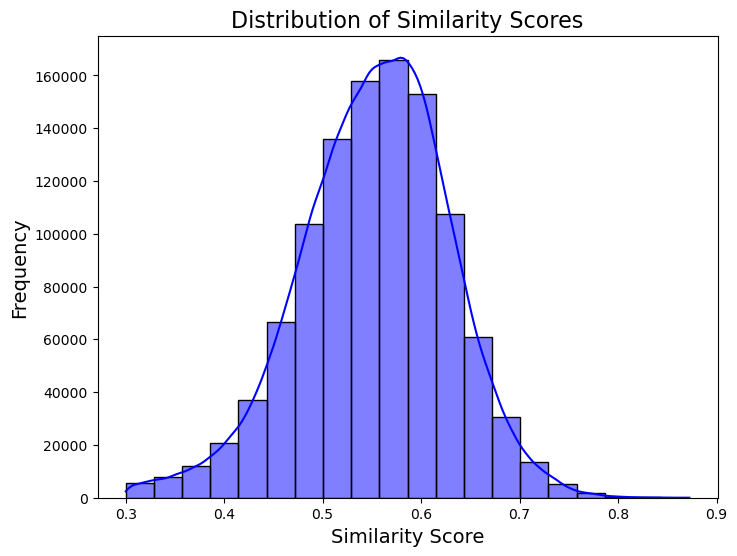

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract the similarity scores from the DataFrame
similarity_scores = results_df['similarity']

# Set the plot size
plt.figure(figsize=(8, 6))

# Use seaborn to create a histogram of the similarity scores
sns.histplot(similarity_scores, bins=20, kde=True, color='blue')

# Add labels and title
plt.title('Distribution of Similarity Scores', fontsize=16)
plt.xlabel('Similarity Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()


In [20]:
# Filter the DataFrame for similarity scores >= 0.8
results_df08 = results_df[results_df['similarity'] >= 0.8]

In [21]:
results_df08.shape

(280, 3)

In [22]:
from rdkit.Chem import Draw
# Set the maximum number of molecules to display
Draw.IPythonConsole.maxMols = 300  # or any other number you want

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
from IPython.display import display

# Function to visualize SMILES strings in batches with zinc_id labels
def show_all_molecule_structures(df, batch_size=100, mols_per_row=3):
    # Get all SMILES strings and zinc_ids in the dataframe
    smiles_list = df['sanitized_smiles'].tolist()
    zinc_ids = df['zinc_id'].tolist()

    # Convert SMILES strings to RDKit Mol objects
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    # Process the molecules in batches to avoid overloading
    for i in range(0, len(mols), batch_size):
        mol_batch = mols[i:i + batch_size]  # Select a batch of molecules
        labels_batch = [f'ZINC ID: {zinc_ids[j]}' for j in range(i, i + len(mol_batch))]  # Select the corresponding labels

        # Display the molecules in a grid with labels
        img = Draw.MolsToGridImage(mol_batch, molsPerRow=mols_per_row, subImgSize=(300, 300), legends=labels_batch)
        display(img)


c:\Users\xueli\miniconda3\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


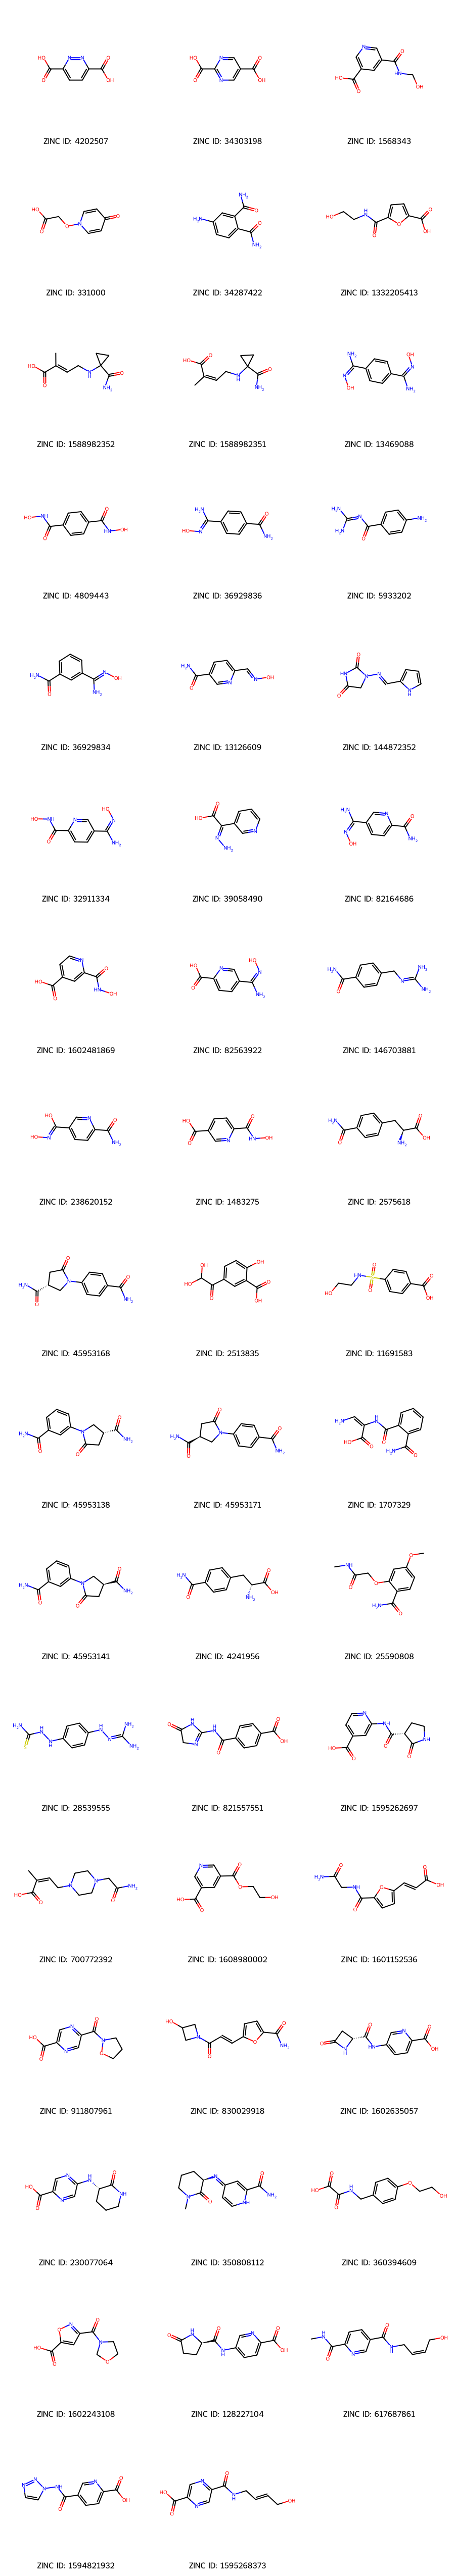

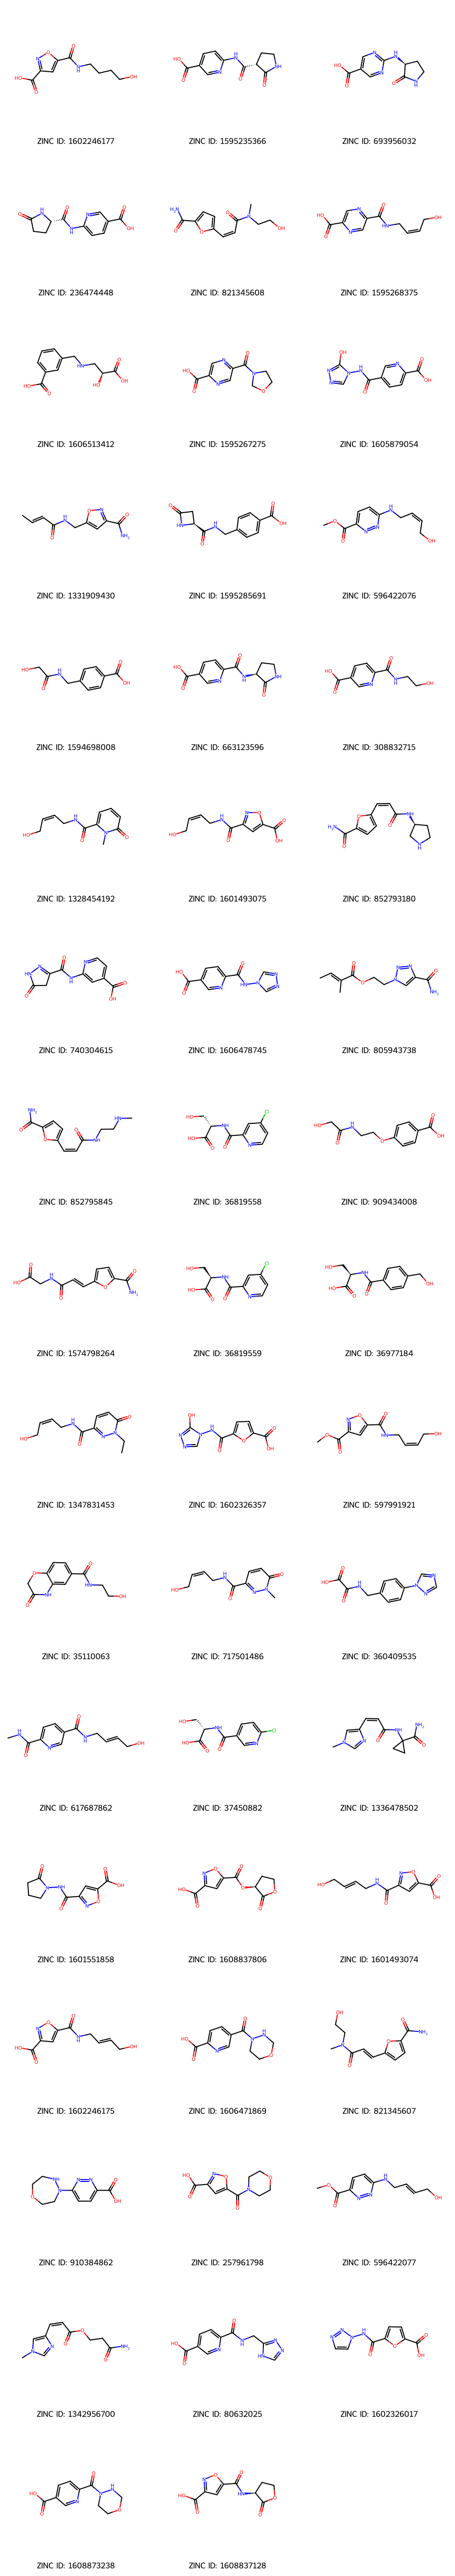

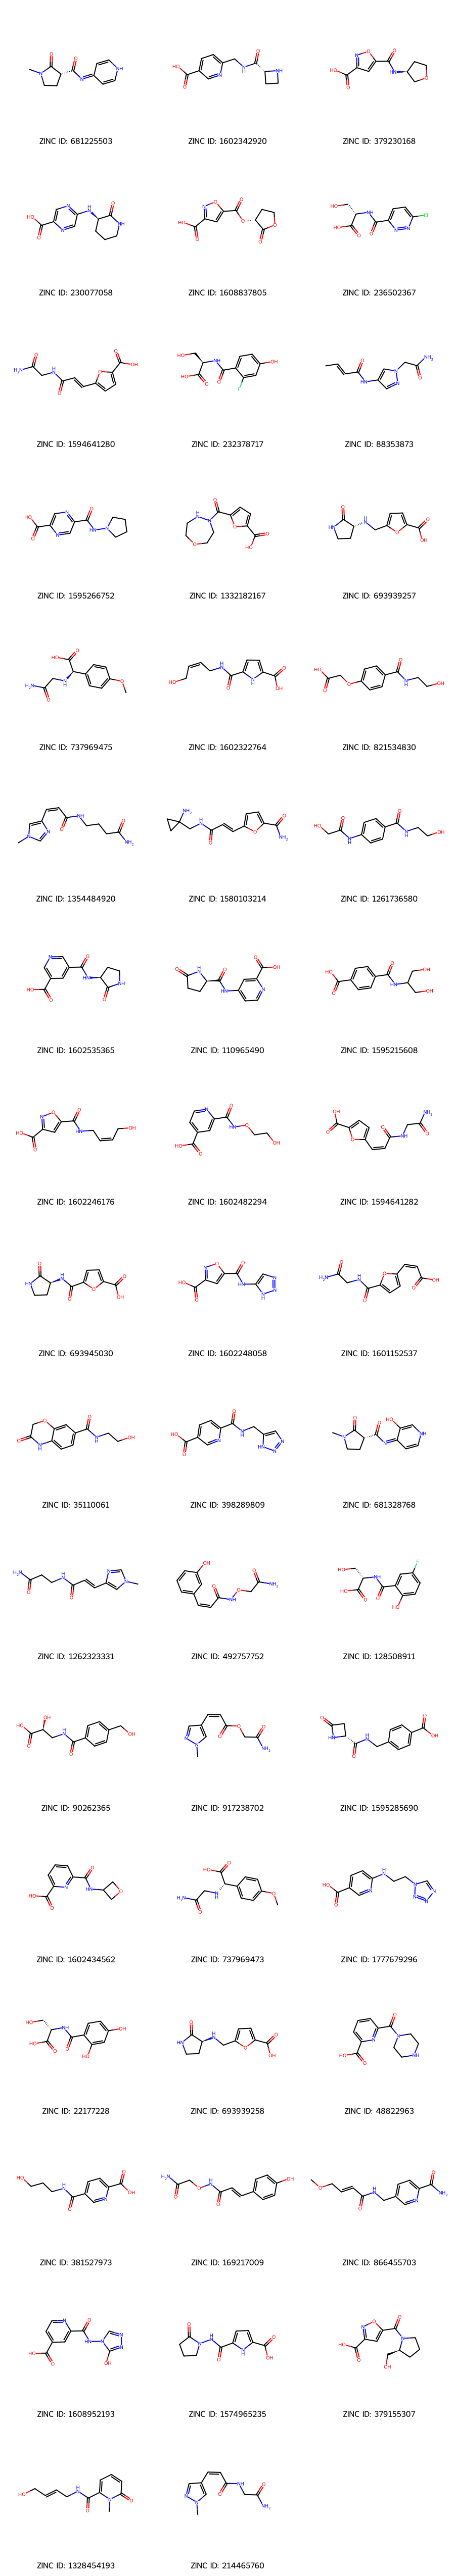

In [24]:
show_all_molecule_structures(results_df08, batch_size=100, mols_per_row=3)